In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterativestratification/.travis.yml
/kaggle/input/iterativestratification/setup.cfg
/kaggle/input/iterativestratification/LICENSE
/kaggle/input/iterativestratification/.gitignore
/kaggle/input/iterativestratification/README.md
/kaggle/input/iterativestratification/setup.py
/kaggle/input/iterativestratification/tests/test_ml_stratifiers.py
/kaggle/input/iterativestratification/tests/__init__.py
/kaggle/input/iterativestratification/iterstrat/ml_stratifiers.py
/kaggle/input/iterativestratification/iterstrat/__init__.py
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [75]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import QuantileTransformer



# **Reading the Data Files**

In [76]:
os.listdir('../input/lish-moa')

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

# ***RankGauss on Train & Test Data Set***

In [77]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]



for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
    

# **PCA + Normal Features**

In [78]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [79]:
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [80]:
n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [81]:
train_features.shape

(23814, 1526)

# **BEST FEATURE SELECTION(VARIANCE ENCODING)**

In [82]:
from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(0.8)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)


train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

train_features.shape


(23814, 1040)

# **CV FOLDS**

In [83]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)


print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)
folds

(21948, 1245)
(21948, 1246)
(3624, 1039)
(21948, 207)
(3982, 207)


,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,0,0,0,0,0,0,0,0,0,5
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,0,0,0,0,0,0,0,0,0,6
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.237856,-1.228203,0.218376,-0.365976,-0.330177,0.569243,-0.150978,...,0,0,0,0,0,0,0,0,0,5
21944,id_fffb1ceed,24,D2,0.209361,-0.022389,-0.235888,-0.796989,-0.674009,0.919312,0.735603,...,0,0,0,0,0,0,0,0,0,1
21945,id_fffb70c0c,24,D2,-1.911021,0.587228,-0.588417,1.296405,-1.002640,0.850589,-0.304313,...,0,0,0,0,0,0,0,0,0,5
21946,id_fffcb9e7c,24,D1,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,...,0,0,0,0,0,0,0,0,0,1


# **DEFINING CLASSES(DATASET,TRAIN,VALID,INFERENCE)**

In [84]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds
   


# **MODEL**

In [85]:
class Model(nn.Module):      # <-- Update
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.4)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.4)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

# **PREPROCESSING DATA**

In [86]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

1041

# **HYPERPARAMETERS**

In [87]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7              #<-- Update
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=2048

In [88]:
# to plot validation loss
train_loss_ = []
# to plot the training loss
valid_loss_ = []
# to plot the best recorded loss
best_loss_ = []

# **DEFINING SINGLE AND MULTIFOLD TRAINING FUNCTION**

In [89]:
def run_training(fold, seed):
    global train_loss_
    global valid_loss_
    global best_loss_
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        train_loss_.append(train_loss)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        valid_loss_.append(valid_loss)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            best_loss_.append(best_loss)
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions
            
    
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions        
    
    

# **TRAINING AND TESTING**

In [90]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3 ,4, 5 ,6]  #<-- Update
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

FOLD: 0, EPOCH: 0, train_loss: 0.48232868185811706
FOLD: 0, EPOCH: 0, valid_loss: 0.024814292937517166
FOLD: 0, EPOCH: 1, train_loss: 0.02107173926672157
FOLD: 0, EPOCH: 1, valid_loss: 0.019315823763608932
FOLD: 0, EPOCH: 2, train_loss: 0.018996933551163088
FOLD: 0, EPOCH: 2, valid_loss: 0.018227280303835868
FOLD: 0, EPOCH: 3, train_loss: 0.01764812731013006
FOLD: 0, EPOCH: 3, valid_loss: 0.017300846874713897
FOLD: 0, EPOCH: 4, train_loss: 0.017051006686322544
FOLD: 0, EPOCH: 4, valid_loss: 0.017407792396843435
FOLD: 0, EPOCH: 5, train_loss: 0.01694557220250571
FOLD: 0, EPOCH: 5, valid_loss: 0.017122614867985247
FOLD: 0, EPOCH: 6, train_loss: 0.016944134151753113
FOLD: 0, EPOCH: 6, valid_loss: 0.017487628497183324
FOLD: 0, EPOCH: 7, train_loss: 0.01701711434997669
FOLD: 0, EPOCH: 7, valid_loss: 0.017396538332104684
FOLD: 0, EPOCH: 8, train_loss: 0.01705438644327477
FOLD: 0, EPOCH: 8, valid_loss: 0.01718995697796345
FOLD: 0, EPOCH: 9, train_loss: 0.017072569477517587
FOLD: 0, EPOCH: 9, 

FOLD: 3, EPOCH: 4, train_loss: 0.01706478454578085
FOLD: 3, EPOCH: 4, valid_loss: 0.017291972562670708
FOLD: 3, EPOCH: 5, train_loss: 0.01691005484131323
FOLD: 3, EPOCH: 5, valid_loss: 0.01703678574413061
FOLD: 3, EPOCH: 6, train_loss: 0.016993613102707732
FOLD: 3, EPOCH: 6, valid_loss: 0.017195160500705242
FOLD: 3, EPOCH: 7, train_loss: 0.016973940034707386
FOLD: 3, EPOCH: 7, valid_loss: 0.01741372115910053
FOLD: 3, EPOCH: 8, train_loss: 0.017041414481948833
FOLD: 3, EPOCH: 8, valid_loss: 0.017105118930339815
FOLD: 3, EPOCH: 9, train_loss: 0.017077530715234424
FOLD: 3, EPOCH: 9, valid_loss: 0.01728488862514496
FOLD: 3, EPOCH: 10, train_loss: 0.017103633475901724
FOLD: 3, EPOCH: 10, valid_loss: 0.01704591266810894
FOLD: 3, EPOCH: 11, train_loss: 0.01693209360803471
FOLD: 3, EPOCH: 11, valid_loss: 0.01716302376240492
FOLD: 3, EPOCH: 12, train_loss: 0.016991714471761062
FOLD: 3, EPOCH: 12, valid_loss: 0.017050273418426513
FOLD: 3, EPOCH: 13, train_loss: 0.016831964716872795
FOLD: 3, EPOC

FOLD: 6, EPOCH: 8, train_loss: 0.01699756999455747
FOLD: 6, EPOCH: 8, valid_loss: 0.01706769809126854
FOLD: 6, EPOCH: 9, train_loss: 0.017067188118286683
FOLD: 6, EPOCH: 9, valid_loss: 0.01709349926561117
FOLD: 6, EPOCH: 10, train_loss: 0.01708656894106443
FOLD: 6, EPOCH: 10, valid_loss: 0.017170765399932862
FOLD: 6, EPOCH: 11, train_loss: 0.017027468680321765
FOLD: 6, EPOCH: 11, valid_loss: 0.0171413404494524
FOLD: 6, EPOCH: 12, train_loss: 0.016959985889190315
FOLD: 6, EPOCH: 12, valid_loss: 0.016926286593079567
FOLD: 6, EPOCH: 13, train_loss: 0.016871846496399973
FOLD: 6, EPOCH: 13, valid_loss: 0.016968220211565493
FOLD: 6, EPOCH: 14, train_loss: 0.016736460906662504
FOLD: 6, EPOCH: 14, valid_loss: 0.016844660341739655
FOLD: 6, EPOCH: 15, train_loss: 0.016604949758217042
FOLD: 6, EPOCH: 15, valid_loss: 0.016662905737757683
FOLD: 6, EPOCH: 16, train_loss: 0.01640641698170276
FOLD: 6, EPOCH: 16, valid_loss: 0.016386416777968406
FOLD: 6, EPOCH: 17, train_loss: 0.016158468343418875
FOLD

FOLD: 2, EPOCH: 12, train_loss: 0.016934767656889903
FOLD: 2, EPOCH: 12, valid_loss: 0.016820230446755888
FOLD: 2, EPOCH: 13, train_loss: 0.016846961481179916
FOLD: 2, EPOCH: 13, valid_loss: 0.01684346217662096
FOLD: 2, EPOCH: 14, train_loss: 0.016770995874591424
FOLD: 2, EPOCH: 14, valid_loss: 0.01680222399532795
FOLD: 2, EPOCH: 15, train_loss: 0.01662287802821925
FOLD: 2, EPOCH: 15, valid_loss: 0.016849438324570656
FOLD: 2, EPOCH: 16, train_loss: 0.01643636502756351
FOLD: 2, EPOCH: 16, valid_loss: 0.01653080329298973
FOLD: 2, EPOCH: 17, train_loss: 0.01618100652078382
FOLD: 2, EPOCH: 17, valid_loss: 0.016350412815809248
FOLD: 2, EPOCH: 18, train_loss: 0.015904268972119506
FOLD: 2, EPOCH: 18, valid_loss: 0.016287979371845722
FOLD: 2, EPOCH: 19, train_loss: 0.015616927834443088
FOLD: 2, EPOCH: 19, valid_loss: 0.016090837828814982
FOLD: 2, EPOCH: 20, train_loss: 0.0152122767097285
FOLD: 2, EPOCH: 20, valid_loss: 0.015998590104281903
FOLD: 2, EPOCH: 21, train_loss: 0.01480706524560038
FO

FOLD: 5, EPOCH: 16, train_loss: 0.016326379252686388
FOLD: 5, EPOCH: 16, valid_loss: 0.01671287514269352
FOLD: 5, EPOCH: 17, train_loss: 0.016158953613164474
FOLD: 5, EPOCH: 17, valid_loss: 0.016432282850146293
FOLD: 5, EPOCH: 18, train_loss: 0.015841717952165473
FOLD: 5, EPOCH: 18, valid_loss: 0.01636404249817133
FOLD: 5, EPOCH: 19, train_loss: 0.015482104091974749
FOLD: 5, EPOCH: 19, valid_loss: 0.01620681505650282
FOLD: 5, EPOCH: 20, train_loss: 0.015064914064595893
FOLD: 5, EPOCH: 20, valid_loss: 0.01610106658190489
FOLD: 5, EPOCH: 21, train_loss: 0.014674901892589468
FOLD: 5, EPOCH: 21, valid_loss: 0.016018796302378176
FOLD: 5, EPOCH: 22, train_loss: 0.01425523020732565
FOLD: 5, EPOCH: 22, valid_loss: 0.016033078879117965
FOLD: 5, EPOCH: 23, train_loss: 0.013923346166353242
FOLD: 5, EPOCH: 23, valid_loss: 0.015973819121718406
FOLD: 5, EPOCH: 24, train_loss: 0.013731136335199382
FOLD: 5, EPOCH: 24, valid_loss: 0.015963666029274463
FOLD: 6, EPOCH: 0, train_loss: 0.4790377524890462
F

FOLD: 1, EPOCH: 21, train_loss: 0.014766930564477736
FOLD: 1, EPOCH: 21, valid_loss: 0.015693071708083154
FOLD: 1, EPOCH: 22, train_loss: 0.014325511407385878
FOLD: 1, EPOCH: 22, valid_loss: 0.01564443428069353
FOLD: 1, EPOCH: 23, train_loss: 0.013968967224414252
FOLD: 1, EPOCH: 23, valid_loss: 0.015647099018096924
FOLD: 1, EPOCH: 24, train_loss: 0.013801887251284659
FOLD: 1, EPOCH: 24, valid_loss: 0.015616458244621753
FOLD: 2, EPOCH: 0, train_loss: 0.4808703261066456
FOLD: 2, EPOCH: 0, valid_loss: 0.024880244582891464
FOLD: 2, EPOCH: 1, train_loss: 0.02114043458282542
FOLD: 2, EPOCH: 1, valid_loss: 0.018960779719054698
FOLD: 2, EPOCH: 2, train_loss: 0.019015085028142344
FOLD: 2, EPOCH: 2, valid_loss: 0.018345214426517487
FOLD: 2, EPOCH: 3, train_loss: 0.017704928433205806
FOLD: 2, EPOCH: 3, valid_loss: 0.017417233884334565
FOLD: 2, EPOCH: 4, train_loss: 0.017057205670747626
FOLD: 2, EPOCH: 4, valid_loss: 0.017037723585963248
FOLD: 2, EPOCH: 5, train_loss: 0.016898751011764516
FOLD: 2,

FOLD: 5, EPOCH: 0, train_loss: 0.48116053166944966
FOLD: 5, EPOCH: 0, valid_loss: 0.024474337995052338
FOLD: 5, EPOCH: 1, train_loss: 0.021242725276419905
FOLD: 5, EPOCH: 1, valid_loss: 0.019221568256616594
FOLD: 5, EPOCH: 2, train_loss: 0.01915504473584647
FOLD: 5, EPOCH: 2, valid_loss: 0.018231398835778238
FOLD: 5, EPOCH: 3, train_loss: 0.017711482251531817
FOLD: 5, EPOCH: 3, valid_loss: 0.01741752218455076
FOLD: 5, EPOCH: 4, train_loss: 0.017096172359322204
FOLD: 5, EPOCH: 4, valid_loss: 0.01714259386062622
FOLD: 5, EPOCH: 5, train_loss: 0.016921192578667282
FOLD: 5, EPOCH: 5, valid_loss: 0.01710904445499182
FOLD: 5, EPOCH: 6, train_loss: 0.01693627389692733
FOLD: 5, EPOCH: 6, valid_loss: 0.017178003080189228
FOLD: 5, EPOCH: 7, train_loss: 0.017021464893505686
FOLD: 5, EPOCH: 7, valid_loss: 0.017241457104682924
FOLD: 5, EPOCH: 8, train_loss: 0.01703550340290986
FOLD: 5, EPOCH: 8, valid_loss: 0.01723160222172737
FOLD: 5, EPOCH: 9, train_loss: 0.017027757504359396
FOLD: 5, EPOCH: 9, v

FOLD: 1, EPOCH: 4, train_loss: 0.01713164656923539
FOLD: 1, EPOCH: 4, valid_loss: 0.016970947869122028
FOLD: 1, EPOCH: 5, train_loss: 0.016985075694008343
FOLD: 1, EPOCH: 5, valid_loss: 0.01687811132520437
FOLD: 1, EPOCH: 6, train_loss: 0.0169581462420067
FOLD: 1, EPOCH: 6, valid_loss: 0.017028269171714783
FOLD: 1, EPOCH: 7, train_loss: 0.0170263366418935
FOLD: 1, EPOCH: 7, valid_loss: 0.017032364681363106
FOLD: 1, EPOCH: 8, train_loss: 0.01709956949462696
FOLD: 1, EPOCH: 8, valid_loss: 0.016859473325312138
FOLD: 1, EPOCH: 9, train_loss: 0.017098259516567193
FOLD: 1, EPOCH: 9, valid_loss: 0.016962896473705767
FOLD: 1, EPOCH: 10, train_loss: 0.017093646004289188
FOLD: 1, EPOCH: 10, valid_loss: 0.017253718450665475
FOLD: 1, EPOCH: 11, train_loss: 0.017038007501234003
FOLD: 1, EPOCH: 11, valid_loss: 0.016818967461586
FOLD: 1, EPOCH: 12, train_loss: 0.016945465740297927
FOLD: 1, EPOCH: 12, valid_loss: 0.016678593531250955
FOLD: 1, EPOCH: 13, train_loss: 0.016876455339394053
FOLD: 1, EPOCH:

FOLD: 4, EPOCH: 9, train_loss: 0.017092429506940905
FOLD: 4, EPOCH: 9, valid_loss: 0.01714508727192879
FOLD: 4, EPOCH: 10, train_loss: 0.01699684414581782
FOLD: 4, EPOCH: 10, valid_loss: 0.017647585719823836
FOLD: 4, EPOCH: 11, train_loss: 0.01703640858509711
FOLD: 4, EPOCH: 11, valid_loss: 0.017148720137774943
FOLD: 4, EPOCH: 12, train_loss: 0.016899092800813875
FOLD: 4, EPOCH: 12, valid_loss: 0.01697548869997263
FOLD: 4, EPOCH: 13, train_loss: 0.016896867148932956
FOLD: 4, EPOCH: 13, valid_loss: 0.01697954084724188
FOLD: 4, EPOCH: 14, train_loss: 0.016770316237190955
FOLD: 4, EPOCH: 14, valid_loss: 0.016836495585739613
FOLD: 4, EPOCH: 15, train_loss: 0.016583956651338914
FOLD: 4, EPOCH: 15, valid_loss: 0.01671934552490711
FOLD: 4, EPOCH: 16, train_loss: 0.016441541730242523
FOLD: 4, EPOCH: 16, valid_loss: 0.016640160344541074
FOLD: 4, EPOCH: 17, train_loss: 0.016216889213846654
FOLD: 4, EPOCH: 17, valid_loss: 0.016638977155089378
FOLD: 4, EPOCH: 18, train_loss: 0.015947292007657946
F

FOLD: 0, EPOCH: 13, train_loss: 0.01680966264561934
FOLD: 0, EPOCH: 13, valid_loss: 0.01686282854527235
FOLD: 0, EPOCH: 14, train_loss: 0.01678817011542669
FOLD: 0, EPOCH: 14, valid_loss: 0.016908331513404845
FOLD: 0, EPOCH: 15, train_loss: 0.016546346665341025
FOLD: 0, EPOCH: 15, valid_loss: 0.016767378486692904
FOLD: 0, EPOCH: 16, train_loss: 0.01639360764703783
FOLD: 0, EPOCH: 16, valid_loss: 0.016654736511409283
FOLD: 0, EPOCH: 17, train_loss: 0.016151041172596872
FOLD: 0, EPOCH: 17, valid_loss: 0.016599762029945852
FOLD: 0, EPOCH: 18, train_loss: 0.015907456141700145
FOLD: 0, EPOCH: 18, valid_loss: 0.016315866373479367
FOLD: 0, EPOCH: 19, train_loss: 0.015527582201523846
FOLD: 0, EPOCH: 19, valid_loss: 0.016240798234939575
FOLD: 0, EPOCH: 20, train_loss: 0.015213290444847679
FOLD: 0, EPOCH: 20, valid_loss: 0.016115375123918058
FOLD: 0, EPOCH: 21, train_loss: 0.014738682524434157
FOLD: 0, EPOCH: 21, valid_loss: 0.015978024527430534
FOLD: 0, EPOCH: 22, train_loss: 0.0143066251168952

FOLD: 3, EPOCH: 17, train_loss: 0.01611315851182151
FOLD: 3, EPOCH: 17, valid_loss: 0.016500789038836956
FOLD: 3, EPOCH: 18, train_loss: 0.0158379802252261
FOLD: 3, EPOCH: 18, valid_loss: 0.016370026879012584
FOLD: 3, EPOCH: 19, train_loss: 0.015546030827424152
FOLD: 3, EPOCH: 19, valid_loss: 0.016286748014390468
FOLD: 3, EPOCH: 20, train_loss: 0.01514429927227043
FOLD: 3, EPOCH: 20, valid_loss: 0.016149989739060403
FOLD: 3, EPOCH: 21, train_loss: 0.014649596217335487
FOLD: 3, EPOCH: 21, valid_loss: 0.01607527744024992
FOLD: 3, EPOCH: 22, train_loss: 0.014237544131877066
FOLD: 3, EPOCH: 22, valid_loss: 0.016049507446587084
FOLD: 3, EPOCH: 23, train_loss: 0.01387515122413027
FOLD: 3, EPOCH: 23, valid_loss: 0.016010844483971595
FOLD: 3, EPOCH: 24, train_loss: 0.01370518864924405
FOLD: 3, EPOCH: 24, valid_loss: 0.016019597686827182
FOLD: 4, EPOCH: 0, train_loss: 0.47979227096146465
FOLD: 4, EPOCH: 0, valid_loss: 0.023756136819720268
FOLD: 4, EPOCH: 1, train_loss: 0.021278515318725384
FOLD

FOLD: 0, EPOCH: 14, train_loss: 0.016613634715021468
FOLD: 0, EPOCH: 14, valid_loss: 0.016721865385770796
FOLD: 0, EPOCH: 15, train_loss: 0.01655414677700218
FOLD: 0, EPOCH: 15, valid_loss: 0.01675972983241081
FOLD: 0, EPOCH: 16, train_loss: 0.016307498284039042
FOLD: 0, EPOCH: 16, valid_loss: 0.01665621720254421
FOLD: 0, EPOCH: 17, train_loss: 0.016115811247961458
FOLD: 0, EPOCH: 17, valid_loss: 0.016450380235910417
FOLD: 0, EPOCH: 18, train_loss: 0.015851454112400003
FOLD: 0, EPOCH: 18, valid_loss: 0.016329104974865914
FOLD: 0, EPOCH: 19, train_loss: 0.015483193948459463
FOLD: 0, EPOCH: 19, valid_loss: 0.01616803154349327
FOLD: 0, EPOCH: 20, train_loss: 0.015123226287058826
FOLD: 0, EPOCH: 20, valid_loss: 0.016120055578649043
FOLD: 0, EPOCH: 21, train_loss: 0.014706688812699448
FOLD: 0, EPOCH: 21, valid_loss: 0.015983118489384652
FOLD: 0, EPOCH: 22, train_loss: 0.014356004327636998
FOLD: 0, EPOCH: 22, valid_loss: 0.01591516487300396
FOLD: 0, EPOCH: 23, train_loss: 0.01399674737940029

FOLD: 3, EPOCH: 18, train_loss: 0.01579407758402581
FOLD: 3, EPOCH: 18, valid_loss: 0.016480549164116384
FOLD: 3, EPOCH: 19, train_loss: 0.015481043131831957
FOLD: 3, EPOCH: 19, valid_loss: 0.016160260029137133
FOLD: 3, EPOCH: 20, train_loss: 0.01508077405722571
FOLD: 3, EPOCH: 20, valid_loss: 0.016125589348375796
FOLD: 3, EPOCH: 21, train_loss: 0.01465328445746785
FOLD: 3, EPOCH: 21, valid_loss: 0.01603327341377735
FOLD: 3, EPOCH: 22, train_loss: 0.014198744846951394
FOLD: 3, EPOCH: 22, valid_loss: 0.015956933572888375
FOLD: 3, EPOCH: 23, train_loss: 0.013809717919195996
FOLD: 3, EPOCH: 23, valid_loss: 0.015958831161260605
FOLD: 3, EPOCH: 24, train_loss: 0.013649029650909155
FOLD: 3, EPOCH: 24, valid_loss: 0.015935721658170223
FOLD: 4, EPOCH: 0, train_loss: 0.4793169985772396
FOLD: 4, EPOCH: 0, valid_loss: 0.02354385010898113
FOLD: 4, EPOCH: 1, train_loss: 0.021169569127920534
FOLD: 4, EPOCH: 1, valid_loss: 0.01926589161157608
FOLD: 4, EPOCH: 2, train_loss: 0.018858174882119612
FOLD: 

FOLD: 6, EPOCH: 22, train_loss: 0.014351249894215948
FOLD: 6, EPOCH: 22, valid_loss: 0.01585207596421242
FOLD: 6, EPOCH: 23, train_loss: 0.01400099634541338
FOLD: 6, EPOCH: 23, valid_loss: 0.01584040280431509
FOLD: 6, EPOCH: 24, train_loss: 0.013842605865326058
FOLD: 6, EPOCH: 24, valid_loss: 0.01585599847137928
FOLD: 0, EPOCH: 0, train_loss: 0.4819419159725004
FOLD: 0, EPOCH: 0, valid_loss: 0.029000962823629378
FOLD: 0, EPOCH: 1, train_loss: 0.021385736243964053
FOLD: 0, EPOCH: 1, valid_loss: 0.019841325730085374
FOLD: 0, EPOCH: 2, train_loss: 0.018879663553975877
FOLD: 0, EPOCH: 2, valid_loss: 0.01818448305130005
FOLD: 0, EPOCH: 3, train_loss: 0.017701370204437752
FOLD: 0, EPOCH: 3, valid_loss: 0.017391722984611988
FOLD: 0, EPOCH: 4, train_loss: 0.017063813816223825
FOLD: 0, EPOCH: 4, valid_loss: 0.017066823914647103
FOLD: 0, EPOCH: 5, train_loss: 0.01689318541538756
FOLD: 0, EPOCH: 5, valid_loss: 0.017039356790482997
FOLD: 0, EPOCH: 6, train_loss: 0.016870030658129528
FOLD: 0, EPOCH

FOLD: 3, EPOCH: 1, train_loss: 0.02132698240987703
FOLD: 3, EPOCH: 1, valid_loss: 0.019514541029930114
FOLD: 3, EPOCH: 2, train_loss: 0.01892708204559931
FOLD: 3, EPOCH: 2, valid_loss: 0.01798509865999222
FOLD: 3, EPOCH: 3, train_loss: 0.01769003870763949
FOLD: 3, EPOCH: 3, valid_loss: 0.017789019122719765
FOLD: 3, EPOCH: 4, train_loss: 0.017002633120231078
FOLD: 3, EPOCH: 4, valid_loss: 0.01731603778898716
FOLD: 3, EPOCH: 5, train_loss: 0.016890021642910785
FOLD: 3, EPOCH: 5, valid_loss: 0.01730370569974184
FOLD: 3, EPOCH: 6, train_loss: 0.016908648797646673
FOLD: 3, EPOCH: 6, valid_loss: 0.017231047414243222
FOLD: 3, EPOCH: 7, train_loss: 0.016987193147746885
FOLD: 3, EPOCH: 7, valid_loss: 0.017173033282160757
FOLD: 3, EPOCH: 8, train_loss: 0.016991135334836788
FOLD: 3, EPOCH: 8, valid_loss: 0.017132566347718238
FOLD: 3, EPOCH: 9, train_loss: 0.01698526016556892
FOLD: 3, EPOCH: 9, valid_loss: 0.017188773714005946
FOLD: 3, EPOCH: 10, train_loss: 0.016971099120723147
FOLD: 3, EPOCH: 10

FOLD: 6, EPOCH: 5, train_loss: 0.016926547778504237
FOLD: 6, EPOCH: 5, valid_loss: 0.01710812121629715
FOLD: 6, EPOCH: 6, train_loss: 0.0170036763282252
FOLD: 6, EPOCH: 6, valid_loss: 0.017142675705254077
FOLD: 6, EPOCH: 7, train_loss: 0.017026163301855125
FOLD: 6, EPOCH: 7, valid_loss: 0.01723992347717285
FOLD: 6, EPOCH: 8, train_loss: 0.017082421558902782
FOLD: 6, EPOCH: 8, valid_loss: 0.01707722622901201
FOLD: 6, EPOCH: 9, train_loss: 0.017043254129132445
FOLD: 6, EPOCH: 9, valid_loss: 0.01698746148496866
FOLD: 6, EPOCH: 10, train_loss: 0.017063623471629052
FOLD: 6, EPOCH: 10, valid_loss: 0.01691389985382557
FOLD: 6, EPOCH: 11, train_loss: 0.01701099362832551
FOLD: 6, EPOCH: 11, valid_loss: 0.016918593309819697
FOLD: 6, EPOCH: 12, train_loss: 0.016962517496375812
FOLD: 6, EPOCH: 12, valid_loss: 0.016884964928030967
FOLD: 6, EPOCH: 13, train_loss: 0.016819300206035982
FOLD: 6, EPOCH: 13, valid_loss: 0.017013469077646733
FOLD: 6, EPOCH: 14, train_loss: 0.016720949387063786
FOLD: 6, EP

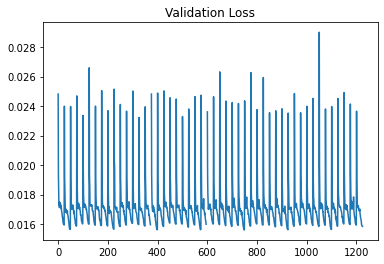

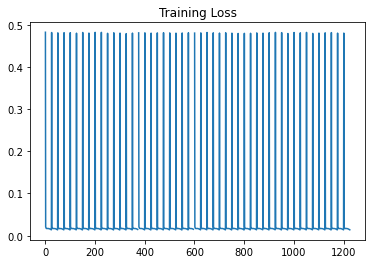

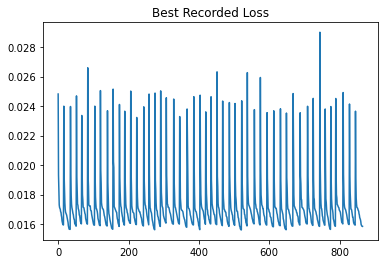

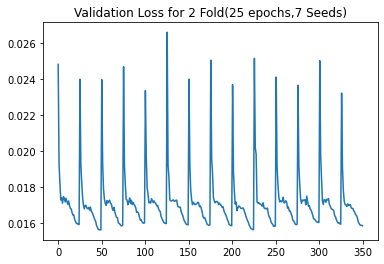

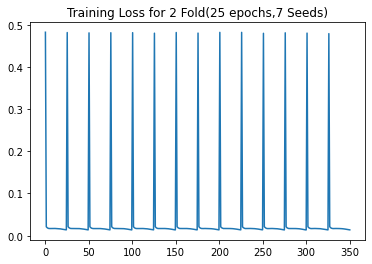

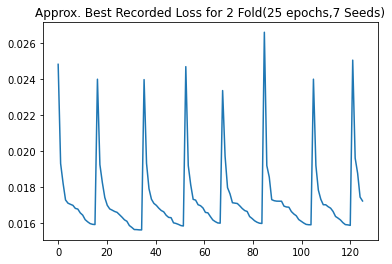

In [99]:
import matplotlib.pyplot as plt 
import numpy as np
x = np.linspace(0,1225,1225);
plt.title("Validation Loss")
plt.plot(x,valid_loss_)
plt.show()

x = np.linspace(0,1225,1225);
plt.title("Training Loss")
plt.plot(x,train_loss_)
plt.show()

x = np.linspace(0,865,865);
plt.title("Best Recorded Loss")
plt.plot(x,best_loss_)
plt.show()

x = np.linspace(0,350,350);
plt.title("Validation Loss for 2 Fold(25 epochs,7 Seeds)")
plt.plot(x,valid_loss_[:350])
plt.show()

x = np.linspace(0,350,350);
plt.title("Training Loss for 2 Fold(25 epochs,7 Seeds)")
plt.plot(x,train_loss_[:350])
plt.show()

x = np.linspace(0,125,125);
plt.title("Approx. Best Recorded Loss for 2 Fold(25 epochs,7 Seeds)")
plt.plot(x,best_loss_[:125])
plt.show()

# **CALCULATING LOG LOSS**

In [92]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)

CV log_loss:  0.014467723033458807


# **GENERATING SUBMISSION  FILE**

In [93]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

sub.shape

(3982, 207)